# <center>Machine Learning Optimization</center>
# KAI RU
# Keio university
# ABSTRACT:
# We compared all two tranditional methods of optimization, Black Litterman  as maximum returns of a portfolio and Mean Variance Optimization with new methods of Machine Learning Optimization Nested Clustered Optimization (NCO) and Convex Optimization(CVO) in this paper by optimizing 92 stocks in US market.

# 1. The goal: Build a portfolio from the US stock market, simulate a six-month short-term investment, and evaluate the actual return by comparing the all 5 models. We use SP100 dataset which contain 92 stocks without missing data.

## (1) As external information, it is first necessary to know the risk-free interest rate and market price. Measured using the 52 Week Treasury Bill as a risk-free interest rate.

In [1]:
#Simulation period
import datetime
datetime.datetime(2019, 7, 4)-datetime.datetime(2010, 6, 16)

datetime.timedelta(days=3305)

In [2]:
import datetime
datetime.datetime(2020, 1, 1)-datetime.datetime(2019, 7, 5)

datetime.timedelta(days=180)

In [3]:
3305/(52*7)

9.07967032967033

In [4]:
import quandl
quandl.ApiConfig.api_key = 'DxKMsvF36hXo5BAMpeDK'
Wk_Bank_Discount_Rate_52=quandl.get("USTREASURY/BILLRATES" ,
                          start_date=datetime.datetime(2010, 6, 16), 
                          end_date=datetime.datetime(2019, 7, 4))

In [5]:
#Downloading bond price
yield_list=[]
for i in range(10):
    yield_list.append(Wk_Bank_Discount_Rate_52[datetime.datetime(2010, 6, 16)+datetime.timedelta(days=364*i):]\
                      ["52 Wk Bank Discount Rate"][0])

In [6]:
yield_list

[0.28, 0.18, 0.17, 0.13, 0.1, 0.26, 0.58, 1.14, 2.24, 1.99]

## Simulation period Yield from October 1, 2012 to September 12, 2019 S = (1 + S0) x (1 + S1) x (1 + S2) x (1 + S3) x (1 + S4 ) x(1 + S5)x(1 + S6)x(1 + S7)x(1 + S8)x(1 + S9) -1

In [7]:
S=(1+yield_list[0]/100)*(1+yield_list[1]/100)*(1+yield_list[2]/100)*\
(1+yield_list[3]/100)*(1+yield_list[4]/100)*(1+yield_list[5]/100)*(1+yield_list[6]/100)\
*(1+yield_list[7]/100)*(1+yield_list[8]/100)*(1+yield_list[9]*(3305/((52*7)*10))/100)-1

In [8]:
S

0.07075832744810984

## If you invest $1 in the bond on June 16, 2010, you will have an asset of 1.072 on March 17, 2020. This is defined as a safe asset, and the interest rate of this safe asset is a risk-free interest rate.

In [9]:
risk_free=S

In [10]:
risk_free

0.07075832744810984

In [11]:
risk_free_annual=risk_free/9.07967032967033

In [12]:
risk_free_annual

0.007793050284754003

## Risk-free interest rate for simulation period

In [13]:
import quandl
quandl.ApiConfig.api_key = 'DxKMsvF36hXo5BAMpeDK'
Wk_Bank_Discount_Rate_8=quandl.get("USTREASURY/BILLRATES" ,
                          start_date=datetime.datetime(2019, 7, 5), 
                          end_date=datetime.datetime(2020, 1, 1))

In [14]:
datetime.datetime(2020, 1, 1)-datetime.datetime(2019, 10, 3)

datetime.timedelta(days=90)

In [15]:
#Downloading bond price
rate_free_simulation=(Wk_Bank_Discount_Rate_8["8 Wk Bank Discount Rate"][0]/100+1)\
      *(Wk_Bank_Discount_Rate_8["8 Wk Bank Discount Rate"][datetime.datetime(2019, 10, 3)]/100+1)-1

rate_free_simulation

0.03937496000000018

## (3) Download the selected stocks as Training Datasets

In [16]:
import pandas as pd
import numpy as np
data=pd.read_excel("S&P 100 constituents Aktienkurse.xlsx",encoding="SHIFT-JIS",header=3)
data=data.drop(labels=0)
data=data.reset_index(drop= True)
data.index=data["Name"]
data=data.drop(["Name"],axis=1)
data=data.dropna(axis=1)
symbols = data.columns
df = data[symbols]
df=df.astype("float")
data=df[datetime.datetime(2010, 6, 16):datetime.datetime(2019, 12, 18)]

In [17]:
data.head()

AMAZON.COM  ABBOTT LABORATORIES  INTERNATIONAL BUS.MCHS.  \
Name                                                                   
2010-06-17     125.890              23.2682                   130.98   
2010-06-18     125.830              23.3351                   130.15   
2010-06-21     122.550              23.1103                   130.65   
2010-06-22     122.307              22.9619                   129.30   
2010-06-23     121.450              22.7562                   130.11   

            ADOBE (NAS)  ALLSTATE ORD SHS  HONEYWELL INTL.  AMGEN  \
Name                                                                
2010-06-17      33.1200             30.06          40.6034  55.44   
2010-06-18      33.5200             30.54          40.8605  55.20   
2010-06-21      33.1300             30.27          40.8700  56.52   
2010-06-22      32.7625             30.55          40.1750  56.12   
2010-06-23      30.3800             30.45          39.8323  56.20   

            AMERICAN EXPRESS  AMERICAN INTL.GP.  COMCAST A  ...  \
Name                                                        ...   
2010-06-17             42.06            31.6433      9.290  ...   
2010-06-18             42.03            31.7606      9.255  ...   
2010-06-21             42.60            32.4727      9.175  ...   
2010-06-22             41.94            32.0622      9.120  ...   
2010-06-23             42.17            31.6768      9.090  ...   

            ACCENTURE CLASS A  AMERICAN TOWER  DUKE ENERGY  \
Name                                                         
2010-06-17              38.49           44.97        50.13   
2010-06-18              38.93           45.07        49.92   
2010-06-21              38.81           45.12        49.77   
2010-06-22              38.24           44.37        48.96   
2010-06-23              38.17           44.71        48.66   

            MONDELEZ INTERNATIONAL CL.A  BOOKING HOLDINGS  \
Name                                                        
2010-06-17                      19.6153            195.26   
2010-06-18                      19.6350            193.09   
2010-06-21                      19.5892            189.25   
2010-06-22                      19.2097            188.95   
2010-06-23                      19.3275            188.25   

            RAYTHEON TECHNOLOGIES  MEDTRONIC  WALGREENS BOOTS ALLIANCE  \
Name                                                                     
2010-06-17                40.4377      38.97                     29.27   
2010-06-18                40.8034      38.87                     30.09   
2010-06-21                40.9155      38.68                     30.14   
2010-06-22                40.1015      38.08                     28.17   
2010-06-23                40.1015      37.51                     28.13   

            ALPHABET A  CHARTER COMMS.CL.A  
Name                                        
2010-06-17    250.2825             38.4317  
2010-06-18    250.2575             38.9847  
2010-06-21    244.5169             38.9847  
2010-06-22    243.3609             39.2612  
2010-06-23    241.2588             39.4271  

[5 rows x 92 columns]

## (4) Plot time series transition and rate of return

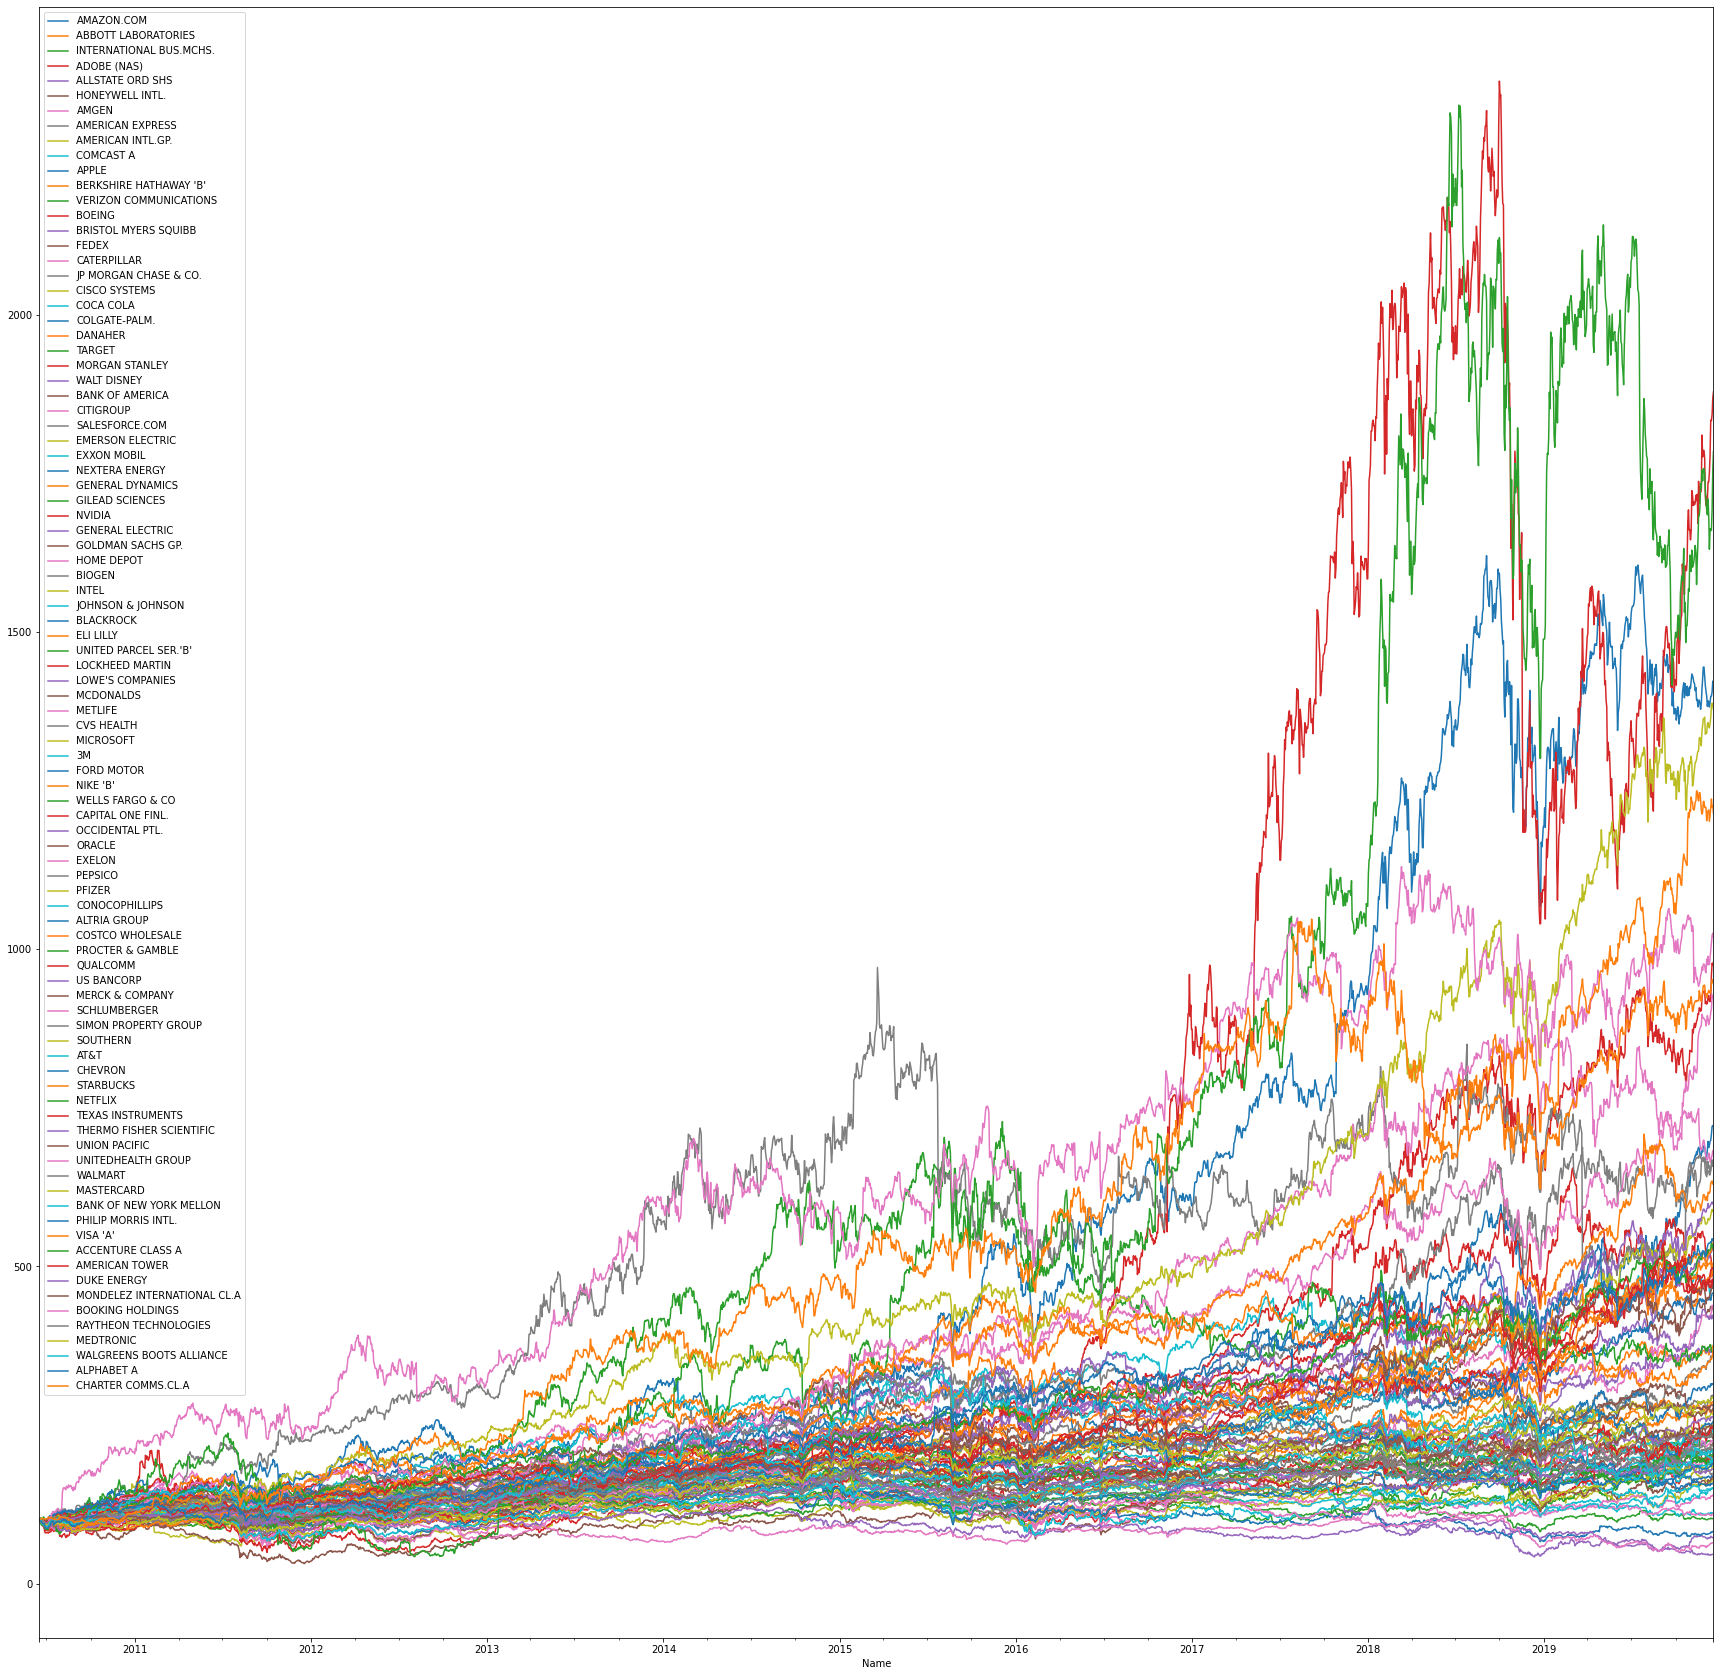

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
(data / data.iloc[0] * 100).plot(figsize=(30, 30))
plt.savefig('stat_01.png')

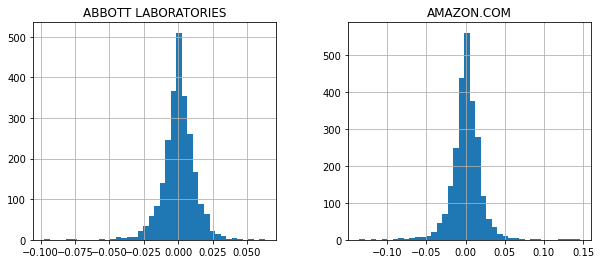

In [19]:
noa = len(symbols)
data = data[symbols]
rets = np.log(data / data.shift(1))
rets[symbols[:2]].hist(bins=40, figsize=(10, 4))
plt.savefig('stat_2.png')

# 2, mean variance model
## (1) Model optimization

In [20]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data,frequency=252)

#mean variance model optimization
EF_min = EfficientFrontier(mu, S)

EF_min.min_volatility()
#portfolio performance
EF_min.portfolio_performance(verbose=True)

Expected annual return: 9.1%
Annual volatility: 10.0%
Sharpe Ratio: 0.71


(0.09073917348377833, 0.10031802484173862, 0.7051491852573475)

In [21]:
#CAPM optimization
#Enter non-risky asset
EF = EfficientFrontier(mu, S,weight_bounds=(-1, 1))
weights = EF.max_sharpe(risk_free_rate=risk_free_annual)
#Portfolio ratio
EF.portfolio_performance(verbose=True)

Expected annual return: 121.0%
Annual volatility: 36.7%
Sharpe Ratio: 3.27


(1.2095219312190972, 0.3669526775015833, 3.2748878932193053)

In [22]:
#Weights in each stock
EF_clean_weights=EF.weights

## (2) Download the data of each stock from March 18, 2020 to June 16, 2020 will be collected for simulation.

In [23]:
import pandas as pd
import numpy as np
data2=pd.read_excel("S&P 100 constituents Aktienkurse.xlsx",encoding="SHIFT-JIS",header=3)
data2=data2.drop(labels=0)
data2=data2.reset_index(drop= True)
data2.index=data2["Name"]
data2=data2.drop(["Name"],axis=1)
data2=data2.dropna(axis=1)
symbols2 = data2.columns
df2 = data2[symbols]
df2=df2.astype("float")
data2=df2[datetime.datetime(2019, 7, 5):datetime.datetime(2020, 1, 1)]

## (2) -2 Covid Download the data of each stock from March 18, 2020 to June 16, 2020 will be collected for simulation.

In [24]:
data3=pd.read_excel("S&P 100 constituents Aktienkurse.xlsx",encoding="SHIFT-JIS",header=3)
data3=data3.drop(labels=0)
data3=data3.reset_index(drop= True)
data3.index=data3["Name"]
data3=data3.drop(["Name"],axis=1)
data3=data3.dropna(axis=1)
symbols3 = data3.columns
data3=data3[datetime.datetime(2019, 12, 19):datetime.datetime(2020, 6, 16)]

## (3) If managed from March 18, 2020 to June 16, 2020, the average return of the portfolio will be
## R = 1r1 + w2r2 + ... + wn * rn
## ri = Return of individual stock
## wi = weight of individual stock
## R = average revenue of the portfolio

In [65]:
Mean_variance_return=np.sum(EF.weights*np.array(expected_returns.mean_historical_return(data2)))
Mean_variance_return
data3_Mean_variance_return=np.sum(EF.weights*np.array(expected_returns.mean_historical_return(data3)))
data3_Mean_variance_return

data4_Mean_variance_return=np.sum(np.maximum(EF.weights,0)*np.array(expected_returns.mean_historical_return(data3)))
data4_Mean_variance_return

-0.1001645952798076

## (4) Volatility of the mean variance model portfolio

In [66]:
from pypfopt import objective_functions
Mean_variance_Volatility=np.sqrt(objective_functions.portfolio_variance(EF.weights, risk_models.sample_cov(data2, frequency=90*252/365)))
Mean_variance_Volatility
data3_Mean_variance_Volatility=np.sqrt(objective_functions.portfolio_variance(EF.weights, risk_models.sample_cov(data3, frequency=90*252/365)))
data3_Mean_variance_Volatility

data4_Mean_variance_Volatility=np.sqrt(objective_functions.portfolio_variance(np.maximum(EF.weights,0), risk_models.sample_cov(data3, frequency=90*252/365)))
data4_Mean_variance_Volatility



2.1314431454775473

# 3. Black – Litterman model

## (1) For the maxmize the Return of portfolio, calculate the actual return of each stock from March 18, 2020 to June 16, 2020

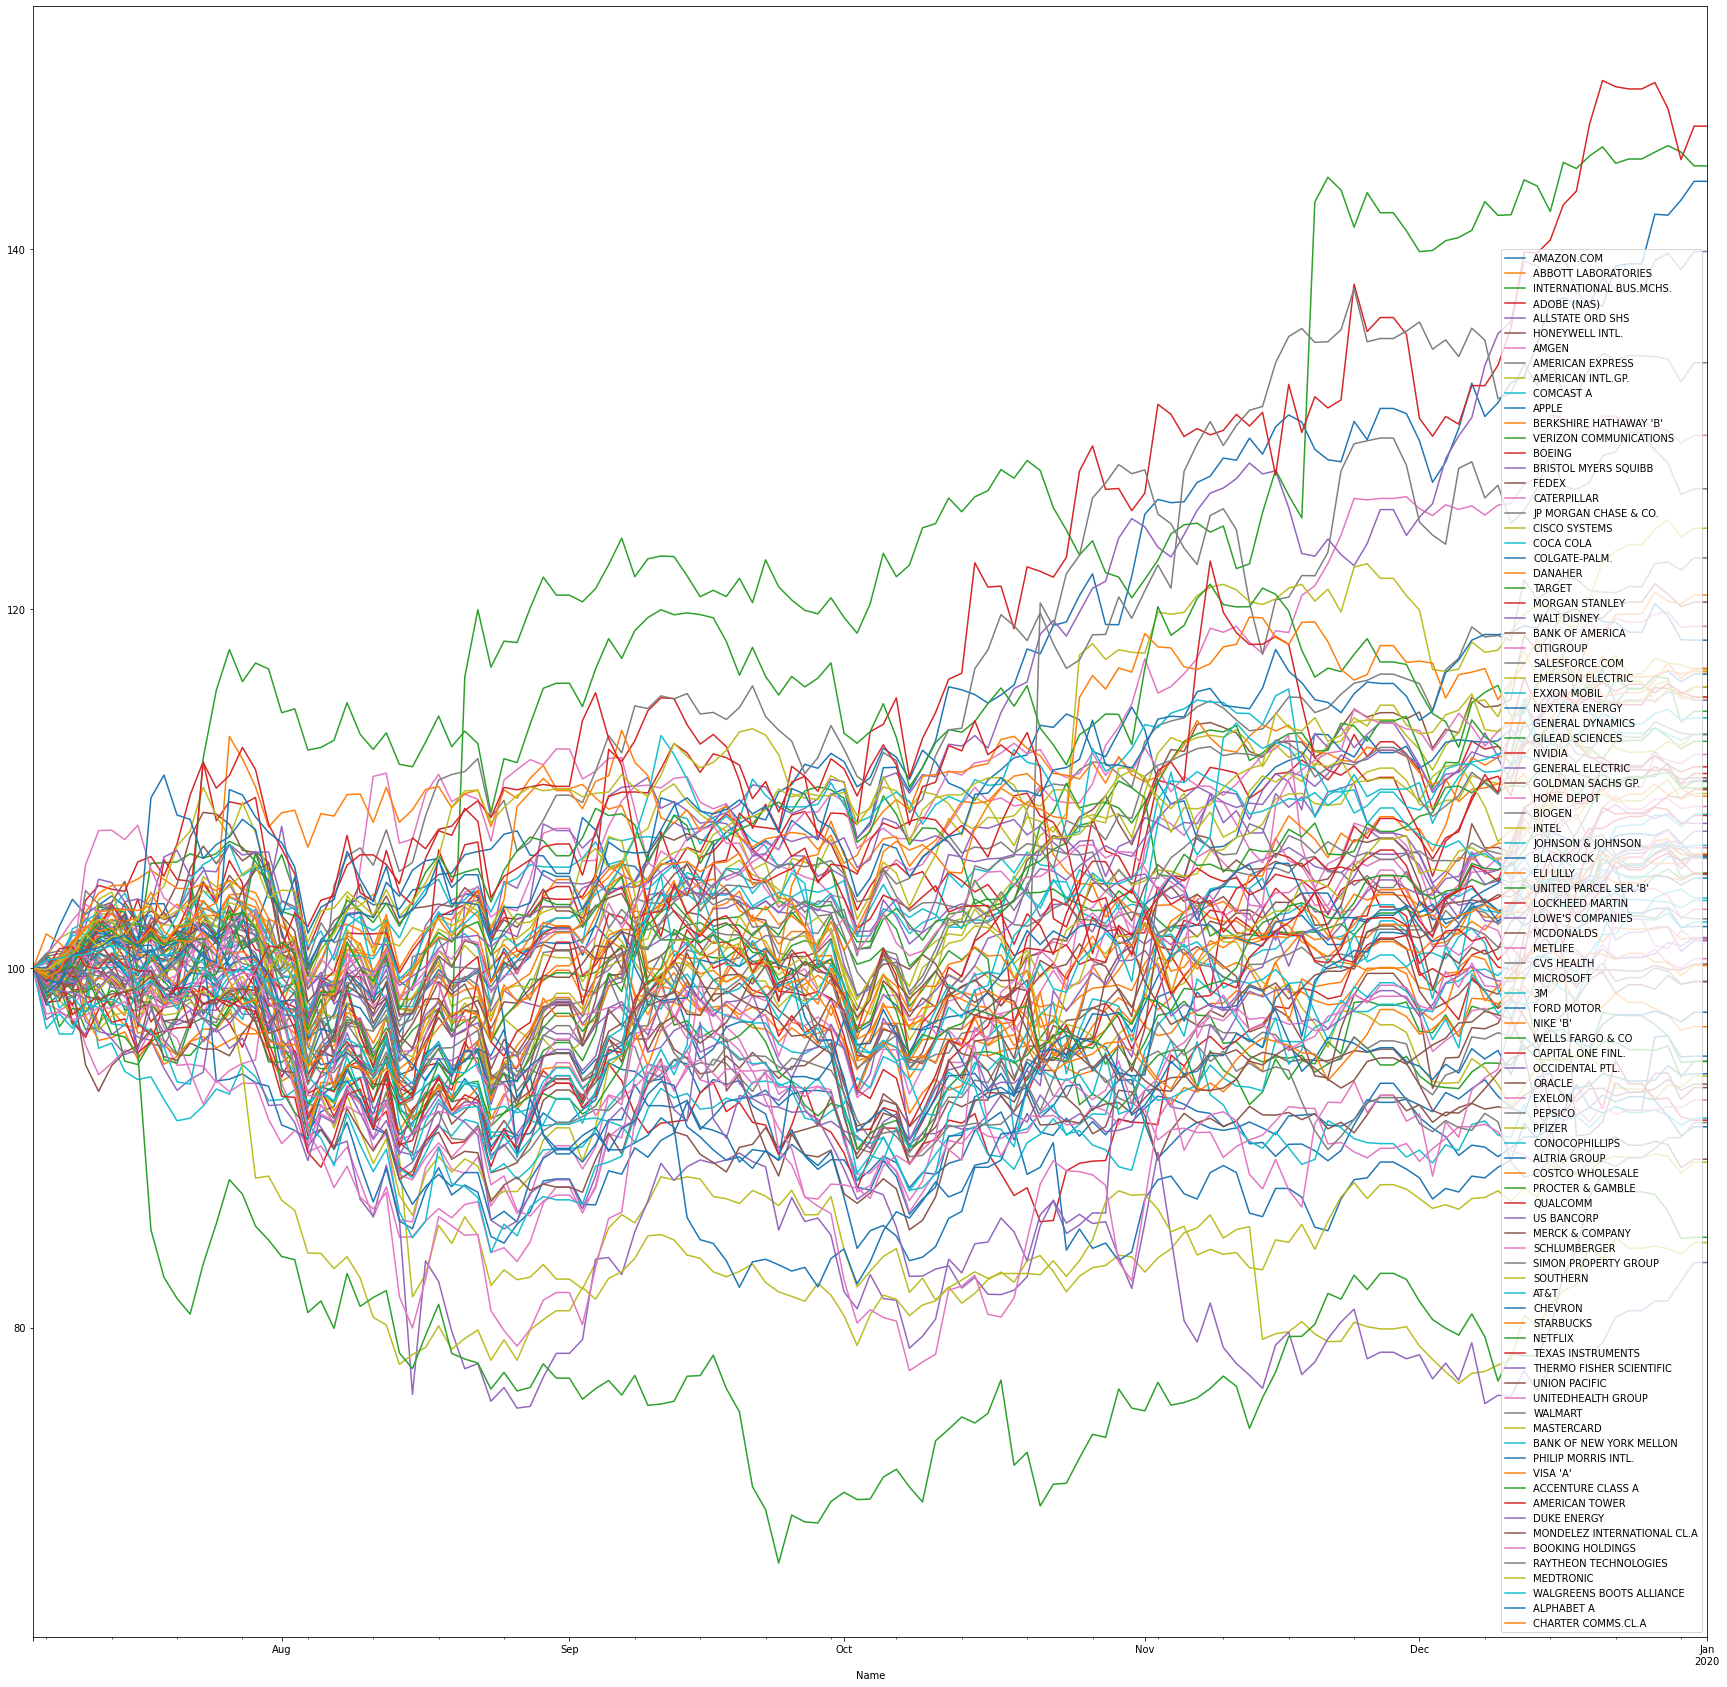

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
(data2 / data2.iloc[0] * 100).plot(figsize=(30, 30))
plt.savefig('stat_02.png')

In [28]:
expected_returns.mean_historical_return(data2)

AMAZON.COM                 -0.094050
ABBOTT LABORATORIES         0.033460
INTERNATIONAL BUS.MCHS.    -0.099640
ADOBE (NAS)                 0.174170
ALLSTATE ORD SHS            0.155508
                              ...   
RAYTHEON TECHNOLOGIES       0.271859
MEDTRONIC                   0.331101
WALGREENS BOOTS ALLIANCE    0.138931
ALPHABET A                  0.391028
CHARTER COMMS.CL.A          0.449794
Length: 92, dtype: float64

## (3) Setting critic reviews for each brand
## Referring to the above figures and data supposed that I could correctly predict the future returns after six months, exactly same as the actual returns above.

In [29]:
from pypfopt.black_litterman import BlackLittermanModel
S = risk_models.sample_cov(data)

viewdict = expected_returns.mean_historical_return(data2, frequency=180*252/365)

In [30]:
bl = BlackLittermanModel(S, absolute_views=viewdict)
rets = bl.bl_returns()

/usr/local/anaconda3/lib/python3.7/site-packages/pypfopt/black_litterman.py:257: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


In [31]:
bl.weights

## (4) Calculate the return of each brand

In [32]:
rets

AMAZON.COM                  0.030890
ABBOTT LABORATORIES         0.064932
INTERNATIONAL BUS.MCHS.     0.013261
ADOBE (NAS)                 0.083895
ALLSTATE ORD SHS            0.057072
                              ...   
RAYTHEON TECHNOLOGIES       0.066101
MEDTRONIC                   0.097625
WALGREENS BOOTS ALLIANCE    0.093773
ALPHABET A                  0.113111
CHARTER COMMS.CL.A          0.120316
Length: 92, dtype: float64

## (5) Introduce SP500 as market price

In [33]:
import pandas_datareader as pdr
SP500 = pdr.get_data_yahoo('^GSPC', 
                          start=datetime.datetime(2010, 6, 16), 
                          end=datetime.datetime(2020, 3, 17))

/usr/local/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [34]:
market_prices=SP500["Close"]

## (6) Black – Litterman model simulation

In [35]:
from pypfopt import black_litterman

delta = black_litterman.market_implied_risk_aversion(market_prices,risk_free_rate=risk_free_annual)



bl.bl_weights(delta)
weights = bl.clean_weights()

In [36]:
bl.portfolio_performance(verbose=True)

Expected annual return: 84.2%
Annual volatility: 35.9%
Sharpe Ratio: 2.29


(0.8416819673775235, 0.35946554224782523, 2.2858434837435233)

In [37]:
Black_Litterman_weights=weights

In [38]:
sum(weights.values())

0.9999799999999996

## (7) If managed from March 18, 2020 to June 16, 2020, the average return of the portfolio will be
## R = 1r1 + w2r2 + ... + wn * rn
## ri = Return of individual stock
## wi = weight of individual stock
## R = average revenue of the portfolio

In [39]:
BL_return=np.sum(np.array(bl.weights)*np.array(expected_returns.mean_historical_return(data2)))

In [40]:
BL_return

5.038821238318581

## (8) Portfolio volatility

In [41]:
from pypfopt import objective_functions
Black_Litterman_volatility=np.sqrt(objective_functions.portfolio_variance(bl.weights, risk_models.sample_cov(data2)))

In [42]:
Black_Litterman_volatility

0.42542507748072506

## 4. Machine Learning Optimization, Nested Clustered Optimization algorithm(NCO), Convex Optimization Solution(CVO) and Monte Carlo approach(MCOS)

## (1)Calculate the Return and Variance of Data

In [43]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
assets_mean=mean_historical_return(data,frequency=252)
assets_cov=sample_cov(data,frequency=252)

## (2)Optimization of NCO & CVO

In [44]:
import pandas as pd
from portfoliolab.clustering import NestedClusteredOptimisation


# Import dataframe of returns for assets in a portfolio
max_num_clusters=91

# Calculate empirical covariance of assets
assets_cov = np.array(assets_cov)

# Calculate empirical means of assets
assets_mean =  np.array(assets_mean).reshape(-1, 1)

# Class that contains needed functions
nco = NestedClusteredOptimisation()

# Find optimal weights using the NCO algorithm
w_nco = nco.allocate_nco(assets_cov, assets_mean,max_num_clusters,n_init=10)

# Find optimal weights using the CVO algorithm
w_cvo = nco.allocate_cvo(assets_cov, assets_mean)


In [45]:
nco_weights= w_nco/sum(w_nco)

In [46]:
cvo_weights=(w_cvo/sum(w_cvo))

## (3)Return of NCO method

In [70]:
NCO_return=np.sum(nco_weights.flatten()*np.array(expected_returns.mean_historical_return(data2)))
NCO_return
data3_NCO_return=np.sum(nco_weights.flatten()*np.array(expected_returns.mean_historical_return(data3)))
data3_NCO_return

data4_NCO_return=np.sum(np.maximum(nco_weights.flatten(),0)*np.array(expected_returns.mean_historical_return(data3)))
data4_NCO_return


0.04430053254540261

## (4)Return of CVO method

In [71]:
CVO_return=np.sum(cvo_weights.flatten()*np.array(expected_returns.mean_historical_return(data2)))
CVO_return
data3_CVO_return=np.sum(cvo_weights.flatten()*np.array(expected_returns.mean_historical_return(data3)))
data3_CVO_return

data4_CVO_return=np.sum(np.maximum(cvo_weights.flatten(),0)*np.array(expected_returns.mean_historical_return(data3)))
data4_CVO_return

-0.09585451173965258

## (5)Volatility of NCO method

In [75]:


NCO_volatility=np.sqrt(objective_functions.portfolio_variance(nco_weights.flatten(), risk_models.sample_cov(data2)))
NCO_volatility
data3_NCO_volatility=np.sqrt(objective_functions.portfolio_variance(nco_weights.flatten(), risk_models.sample_cov(data3)))
data3_NCO_volatility


data4_NCO_volatility=np.sqrt(objective_functions.portfolio_variance(np.maximum(nco_weights.flatten(),0), risk_models.sample_cov(data3)))
data4_NCO_volatility

2.4262606780950344

## (6)Volatility of CVO method

In [76]:
CVO_volatility=np.sqrt(objective_functions.portfolio_variance(cvo_weights.flatten(), risk_models.sample_cov(data2)))
CVO_volatility
data3_CVO_volatility=np.sqrt(objective_functions.portfolio_variance(cvo_weights.flatten(), risk_models.sample_cov(data3)))
data3_CVO_volatility


data4_CVO_volatility=np.sqrt(objective_functions.portfolio_variance(np.maximum(cvo_weights.flatten(),0), risk_models.sample_cov(data3)))
data4_CVO_volatility

4.2278979801565235

In [51]:
# Compare the NCO solutions to the CVO ones using MCOS
# Parameters are: 1 simulations, 2545 observations in a simulation
# goal of maximum sharpe ratio, using LW shrinkage


w_cvo_mcos, w_nco_mcos = nco.allocate_mcos(assets_mean, assets_cov, 2545, 10, 0.01, False, False)

# Find the errors in estimations of NCO and CVO in simulations
err_cvo_mcos, err_nco_mcos = nco.estim_errors_mcos(w_cvo, w_nco, assets_mean, assets_cov, False)

In [77]:
weight_nco_mcos=(w_cvo_mcos.sum(axis=0)/10)/sum((w_cvo_mcos.sum(axis=0)/10))
weight_cvo_mcos=(w_nco_mcos.sum(axis=0)/10)/sum((w_nco_mcos.sum(axis=0)/10))

nco_mcos_performance=sum(np.array(weight_nco_mcos)*np.array(expected_returns.mean_historical_return(data)))
cvo_mcos_performance=sum(np.array(weight_cvo_mcos)*np.array(expected_returns.mean_historical_return(data)))
nco_mcos_performance2=np.sqrt(objective_functions.portfolio_variance(np.array(weight_nco_mcos), (risk_models.sample_cov(data))))
cvo_mcos_performance2=np.sqrt(objective_functions.portfolio_variance(np.array(weight_cvo_mcos), risk_models.sample_cov(data)))


nco_mcos_return=sum(np.array(weight_nco_mcos)*np.array(expected_returns.mean_historical_return(data2)))
cvo_mcos_return=sum(np.array(weight_cvo_mcos)*np.array(expected_returns.mean_historical_return(data2)))
nco_mcos_volatility=np.sqrt(objective_functions.portfolio_variance(np.array(weight_nco_mcos), (risk_models.sample_cov(data2))))
cvo_mcos_volatility=np.sqrt(objective_functions.portfolio_variance(np.array(weight_cvo_mcos), risk_models.sample_cov(data2)))


data3_nco_mcos_return=sum(np.array(weight_nco_mcos)*np.array(expected_returns.mean_historical_return(data3)))
data3_cvo_mcos_return=sum(np.array(weight_cvo_mcos)*np.array(expected_returns.mean_historical_return(data3)))
data3_nco_mcos_volatility=np.sqrt(objective_functions.portfolio_variance(np.array(weight_nco_mcos), (risk_models.sample_cov(data3))))
data3_cvo_mcos_volatility=np.sqrt(objective_functions.portfolio_variance(np.array(weight_cvo_mcos), risk_models.sample_cov(data3)))



data4_nco_mcos_return=sum(np.maximum(np.array(weight_nco_mcos),0)*np.array(expected_returns.mean_historical_return(data3)))
data4_cvo_mcos_return=sum(np.maximum(np.array(weight_cvo_mcos),0)*np.array(expected_returns.mean_historical_return(data3)))
data4_nco_mcos_volatility=np.sqrt(objective_functions.portfolio_variance(np.maximum(np.array(weight_nco_mcos),0), (risk_models.sample_cov(data3))))
data4_cvo_mcos_volatility=np.sqrt(objective_functions.portfolio_variance(np.maximum(np.array(weight_cvo_mcos),0), risk_models.sample_cov(data3)))



# 4, Portfolio comparison

## (1) Portfolio weight comparison

Text(0, 0.5, 'weight')

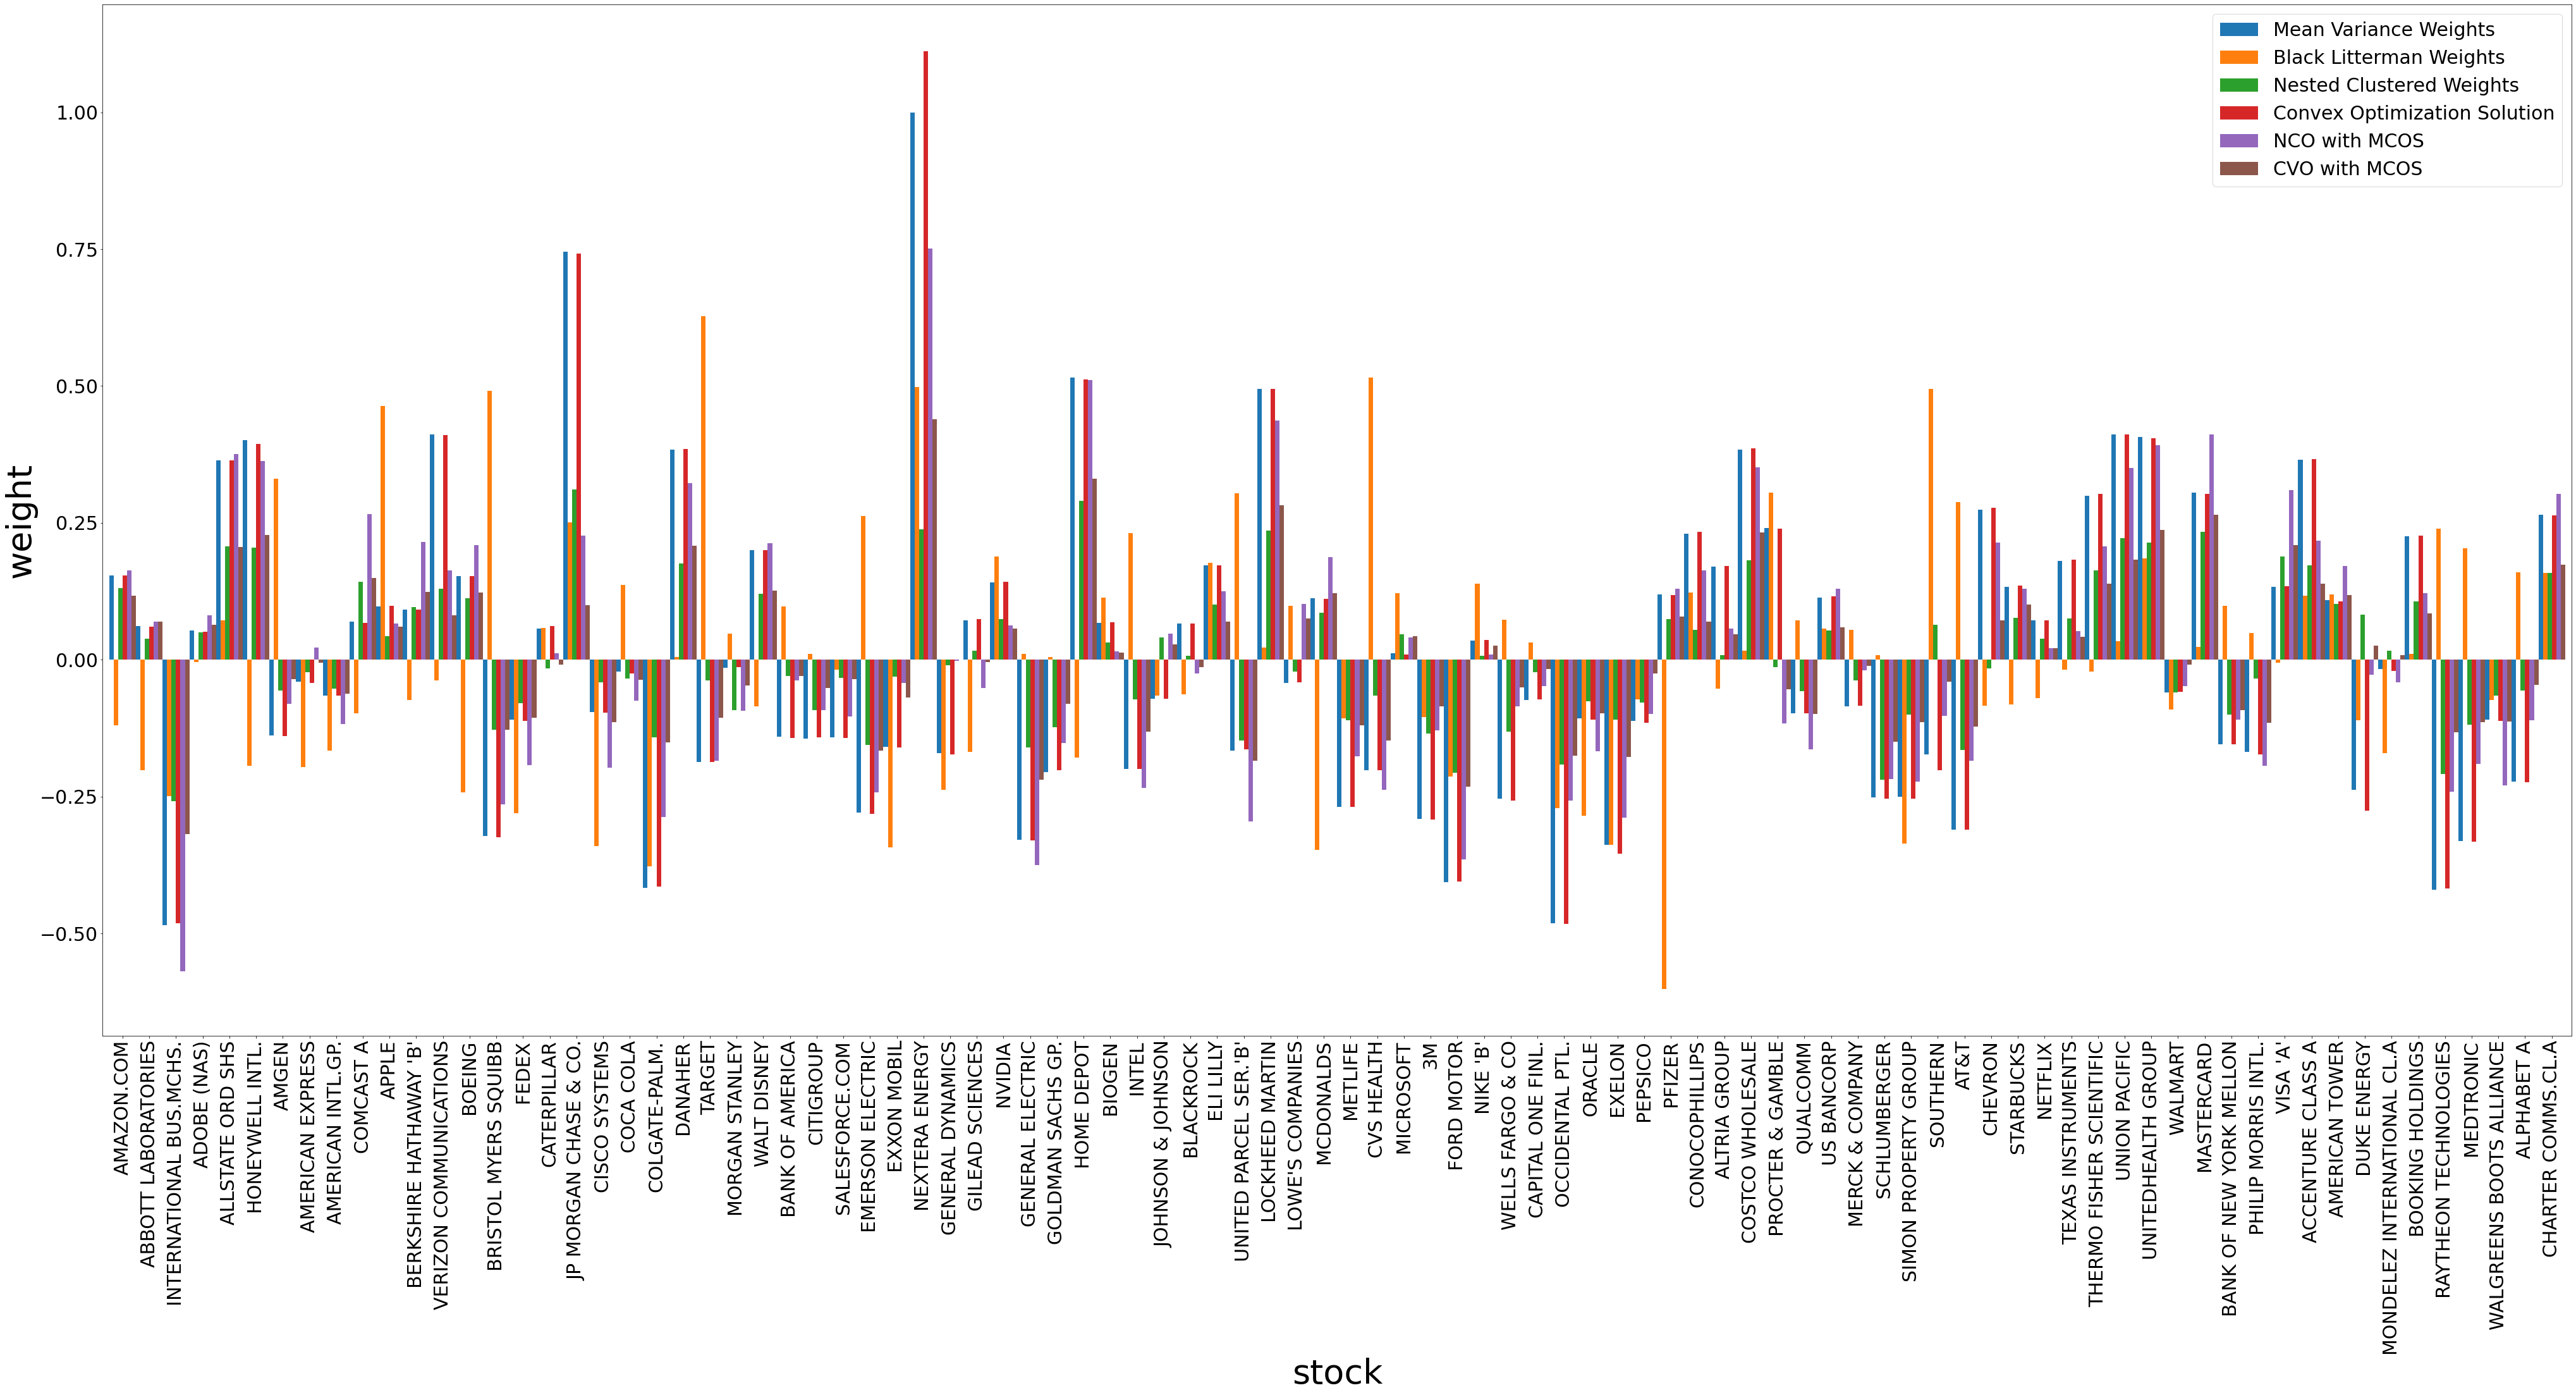

In [500]:
df = pd.DataFrame([EF.weights.reshape(92),np.array(list(bl.weights)).reshape(92),(w_nco/sum(w_nco)).reshape(92),\
                   (w_cvo/sum(w_cvo)).reshape(92),np.array(weight_nco_mcos),np.array(weight_cvo_mcos)],
                  columns=data.columns,
                  index=['Mean Variance Weights','Black Litterman Weights','Nested Clustered Weights','Convex Optimization Solution','NCO with MCOS','CVO with MCOS'])
plot=df.T.plot(kind='bar',figsize=(70, 30),legend=True, fontsize=30,width=1)
plot.legend(loc=1,fontsize=30)
plot.set_xlabel('stock',fontdict={'fontsize':54})
plot.set_ylabel('weight',fontdict={'fontsize':54})

## (2)Comparison of trained portfolios average return and volatility

In [501]:
nco_por_ret=np.sum(nco_weights.flatten()*np.array(expected_returns.mean_historical_return(data, frequency=252)))
cvo_por_ret=np.sum(cvo_weights.flatten()*np.array(expected_returns.mean_historical_return(data, frequency=252)))

       
       
nco_por_var=np.sqrt(objective_functions.portfolio_variance(nco_weights.flatten(), (risk_models.sample_cov(data, frequency=252))))
cvo_por_var=np.sqrt(objective_functions.portfolio_variance(cvo_weights.flatten(), risk_models.sample_cov(data, frequency=252)))

In [502]:
df = pd.DataFrame([[EF.portfolio_performance(verbose=True)[0],bl.portfolio_performance(verbose=True)[0],nco_por_ret,cvo_por_ret,nco_mcos_performance,cvo_mcos_performance],\
                    [EF.portfolio_performance(verbose=True)[1],\
                    bl.portfolio_performance(verbose=True)[1]
                    ,nco_por_var,cvo_por_var,nco_mcos_performance2,cvo_mcos_performance2],\
                    [EF.portfolio_performance(verbose=True)[2],\
                    bl.portfolio_performance(verbose=True)[2]\
                     ,(nco_por_ret-risk_free_annual)/nco_por_var,(cvo_por_ret-risk_free_annual)/cvo_por_var,(nco_mcos_performance-risk_free_annual)/nco_mcos_performance2,(cvo_mcos_performance-risk_free_annual)/cvo_mcos_performance2]],columns=["Mean Variance simulated value","Black Litterman simulated value",'Nested Clustered simulated value','Convex Optimization simulated value',\
                         'NCO with MCOS simulated value','COV with MCOS simulated value'],index=["Return","Volatility","Portfolio Sharpe Ratio"])
    
df

Expected annual return: 131.8%
Annual volatility: 39.1%
Sharpe Ratio: 3.32
Expected annual return: 79.9%
Annual volatility: 34.2%
Sharpe Ratio: 2.28
Expected annual return: 131.8%
Annual volatility: 39.1%
Sharpe Ratio: 3.32
Expected annual return: 79.9%
Annual volatility: 34.2%
Sharpe Ratio: 2.28
Expected annual return: 131.8%
Annual volatility: 39.1%
Sharpe Ratio: 3.32
Expected annual return: 79.9%
Annual volatility: 34.2%
Sharpe Ratio: 2.28


Mean Variance simulated value  \
Return                                       1.317799   
Volatility                                   0.391099   
Portfolio Sharpe Ratio                       3.318338   

                        Black Litterman simulated value  \
Return                                         0.799154   
Volatility                                     0.341644   
Portfolio Sharpe Ratio                         2.280601   

                        Nested Clustered simulated value  \
Return                                          0.789909   
Volatility                                      0.253938   
Portfolio Sharpe Ratio                          3.079948   

                        Convex Optimization simulated value  \
Return                                             1.327950   
Volatility                                         0.393990   
Portfolio Sharpe Ratio                             3.350733   

                        NCO with MCOS simulated value  \
Return                                       1.237470   
Volatility                                   0.397157   
Portfolio Sharpe Ratio                       3.096195   

                        COV with MCOS simulated value  
Return                                       0.837969  
Volatility                                   0.270803  
Portfolio Sharpe Ratio                       3.065601

## (3) Comparison of simulated portfolios average return and volatility

In [568]:
df2 = pd.DataFrame([[Mean_variance_return,BL_return,NCO_return,CVO_return,\
                    nco_mcos_return,cvo_mcos_return],\
                    [Mean_variance_Volatility,\
                    Black_Litterman_volatility
                    ,NCO_volatility,CVO_volatility,nco_mcos_volatility,cvo_mcos_volatility],\
                    [(Mean_variance_return-risk_free_annual)/Mean_variance_Volatility,\
                     (BL_return-risk_free_annual)/Black_Litterman_volatility\
                     ,(NCO_return-risk_free_annual)/NCO_volatility,(CVO_return-risk_free_annual)/CVO_volatility
                    ,(nco_mcos_return-risk_free_annual)/nco_mcos_volatility,(cvo_mcos_return-risk_free_annual)/cvo_mcos_volatility]],columns=["Mean Variance simulated value","Black Litterman simulated value",'Nested Clustered simulated value','Convex Optimization simulated value',\
                         'NCO with MCOS simulated value','COV with MCOS simulated value'],index=["Return","Volatility","Portfolio Sharpe Ratio"])
    
df2

Mean Variance simulated value  \
Return                                       0.671215   
Volatility                                   0.287613   
Portfolio Sharpe Ratio                       2.306650   

                        Black Litterman simulated value  \
Return                                         4.934892   
Volatility                                     0.433405   
Portfolio Sharpe Ratio                        11.368343   

                        Nested Clustered simulated value  \
Return                                          0.367944   
Volatility                                      0.359631   
Portfolio Sharpe Ratio                          1.001448   

                        Convex Optimization simulated value  \
Return                                             0.700696   
Volatility                                         0.586424   
Portfolio Sharpe Ratio                             1.181573   

                        NCO with MCOS simulated value  \
Return                                       0.310424   
Volatility                                   0.602040   
Portfolio Sharpe Ratio                       0.502677   

                        COV with MCOS simulated value  
Return                                       0.295841  
Volatility                                   0.398368  
Portfolio Sharpe Ratio                       0.723068

## (4) Comparison of Covid simulated portfolios average return and volatility

In [86]:
df3 = pd.DataFrame([[data3_Mean_variance_return,data3_NCO_return,data3_CVO_return,\
                    data3_nco_mcos_return,data3_cvo_mcos_return],\
                    [data3_Mean_variance_Volatility
                    ,data3_NCO_volatility,data3_CVO_volatility,data3_nco_mcos_volatility,data3_cvo_mcos_volatility],\
                    [(data3_Mean_variance_return-risk_free_annual)/data3_Mean_variance_Volatility,\
                     (data3_NCO_return-risk_free_annual)/data3_NCO_volatility,(data3_CVO_return-risk_free_annual)/data3_CVO_volatility
                    ,(data3_nco_mcos_return-risk_free_annual)/data3_nco_mcos_volatility,(data3_cvo_mcos_return-risk_free_annual)/data3_cvo_mcos_volatility]],columns=["Mean Variance simulated value",'Nested Clustered simulated value','Convex Optimization simulated value',\
                         'NCO with MCOS simulated value','COV with MCOS simulated value'],index=["Return","Volatility","Portfolio Sharpe Ratio"])
    
df3

Mean Variance simulated value  \
Return                                       2.272084   
Volatility                                   0.564385   
Portfolio Sharpe Ratio                       4.011962   

                        Nested Clustered simulated value  \
Return                                          1.408660   
Volatility                                      0.692469   
Portfolio Sharpe Ratio                          2.023003   

                        Convex Optimization simulated value  \
Return                                             2.233404   
Volatility                                         1.118165   
Portfolio Sharpe Ratio                             1.990413   

                        NCO with MCOS simulated value  \
Return                                       1.996221   
Volatility                                   0.939512   
Portfolio Sharpe Ratio                       2.116447   

                        COV with MCOS simulated value  
Return                                       1.344646  
Volatility                                   0.667084  
Portfolio Sharpe Ratio                       2.004024

In [85]:
df4 = pd.DataFrame([[data4_Mean_variance_return,data4_NCO_return,data4_CVO_return,\
                    data4_nco_mcos_return,data4_cvo_mcos_return],\
                    [data4_Mean_variance_Volatility
                    ,data4_NCO_volatility,data4_CVO_volatility,data4_nco_mcos_volatility,data4_cvo_mcos_volatility],\
                    [(data4_Mean_variance_return-risk_free_annual)/data4_Mean_variance_Volatility,\
                     (data4_NCO_return-risk_free_annual)/data4_NCO_volatility,(data4_CVO_return-risk_free_annual)/data4_CVO_volatility
                    ,(data4_nco_mcos_return-risk_free_annual)/data4_nco_mcos_volatility,(data4_cvo_mcos_return-risk_free_annual)/data4_cvo_mcos_volatility]],columns=["Mean Variance simulated value",'Nested Clustered simulated value','Convex Optimization simulated value',\
                         'NCO with MCOS simulated value','COV with MCOS simulated value'],index=["Return","Volatility","Portfolio Sharpe Ratio"])
    
df4

Mean Variance simulated value  \
Return                                      -0.100165   
Volatility                                   2.131443   
Portfolio Sharpe Ratio                      -0.050650   

                        Nested Clustered simulated value  \
Return                                          0.044301   
Volatility                                      2.426261   
Portfolio Sharpe Ratio                          0.015047   

                        Convex Optimization simulated value  \
Return                                            -0.095855   
Volatility                                         4.227898   
Portfolio Sharpe Ratio                            -0.024515   

                        NCO with MCOS simulated value  \
Return                                       0.117714   
Volatility                                   3.854024   
Portfolio Sharpe Ratio                       0.028521   

                        COV with MCOS simulated value  
Return                                       0.202540  
Volatility                                   2.342933  
Portfolio Sharpe Ratio                       0.083121

# 5, conclusion

# 6, reference list
##  translated by David G. Ruenberger, Hiroshi Konno, Kenichi Suzuki, Norio Bibiki, "Introduction to Financial Engineering: Second Edition," Nihon Keizai Shimbun (2015)
## Takahiro Komatsu “Optimal Investment Strategy” Asakura Shoten (2018)
## PyPortfolioOpt, https://pyportfolioopt.readthedocs.io/en/latest/
## Machine Learning Financial Laboratory (mlfinlab) https://mlfinlab.readthedocs.io/en/latest/index.html
## A ROBUST ESTIMATOR OF THE EFFICIENT FRONTIER https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3469961
## López de Prado Machine Learning for Asset Managers
## López de Prado Advances in Financial Machine Learning